In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import get_formated_region_coords, rotate_region
from astroglial_analysis.classifier2 import *
from astroglial_analysis.pca import get_pcs, get_variance_direction
from astroglial_analysis.plot import plot_pcs
from astroglial_analysis.sub_segmentation import *
from astroglial_analysis.determine_line import (get_line,uniform_align_comp_cell)
from interpolated_function import *
from astroglial_analysis.create_masks import *

2024-10-24 15:58:32,616 [INFO] WRITING LOG OUTPUT TO C:\Users\javid.rezai\.cellpose\run.log
2024-10-24 15:58:32,618 [INFO] 
cellpose version: 	2.3.2 
platform:       	win32 
python version: 	3.9.18 
torch version:  	2.4.0+cpu


In [14]:
p0 = r"..\..\tests\data\combined_mean_image_seg.npy"
masks_file = np.load(p0, allow_pickle=True).item()
masks = masks_file['masks']
# plt.figure(figsize=(20, 10))
# plt.imshow(masks)
# plt.gca().invert_yaxis()
# plt.show()

In [3]:

classifications, body, processes, body_and_processes = classify_masks(masks)

upper, lower = body_and_processes['upper'], body_and_processes['lower']
upper_processes, lower_processes = processes['upper'], processes['lower']

ab_list_upper = [(up, get_ab(get_formated_region_coords(np.where(masks == up)))) for up in upper_processes]
ab_list_lower = [(low, get_ab(get_formated_region_coords(np.where(masks == low)))) for low in lower_processes]


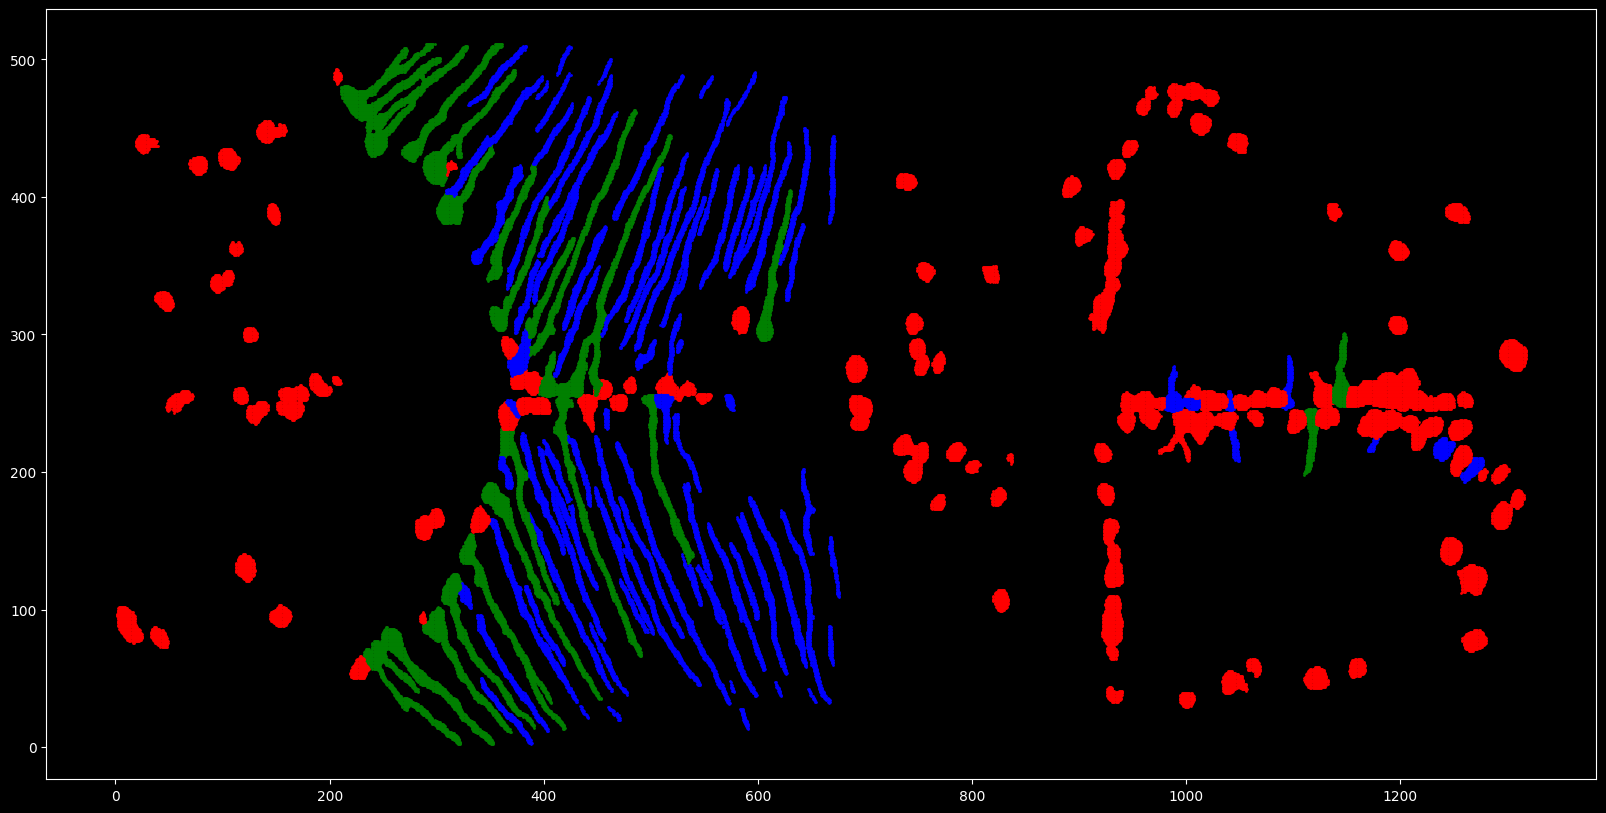

In [4]:
plt.figure(figsize=(20, 10))
visualize_classifications(masks=masks, classifications=classifications)
plt.show()

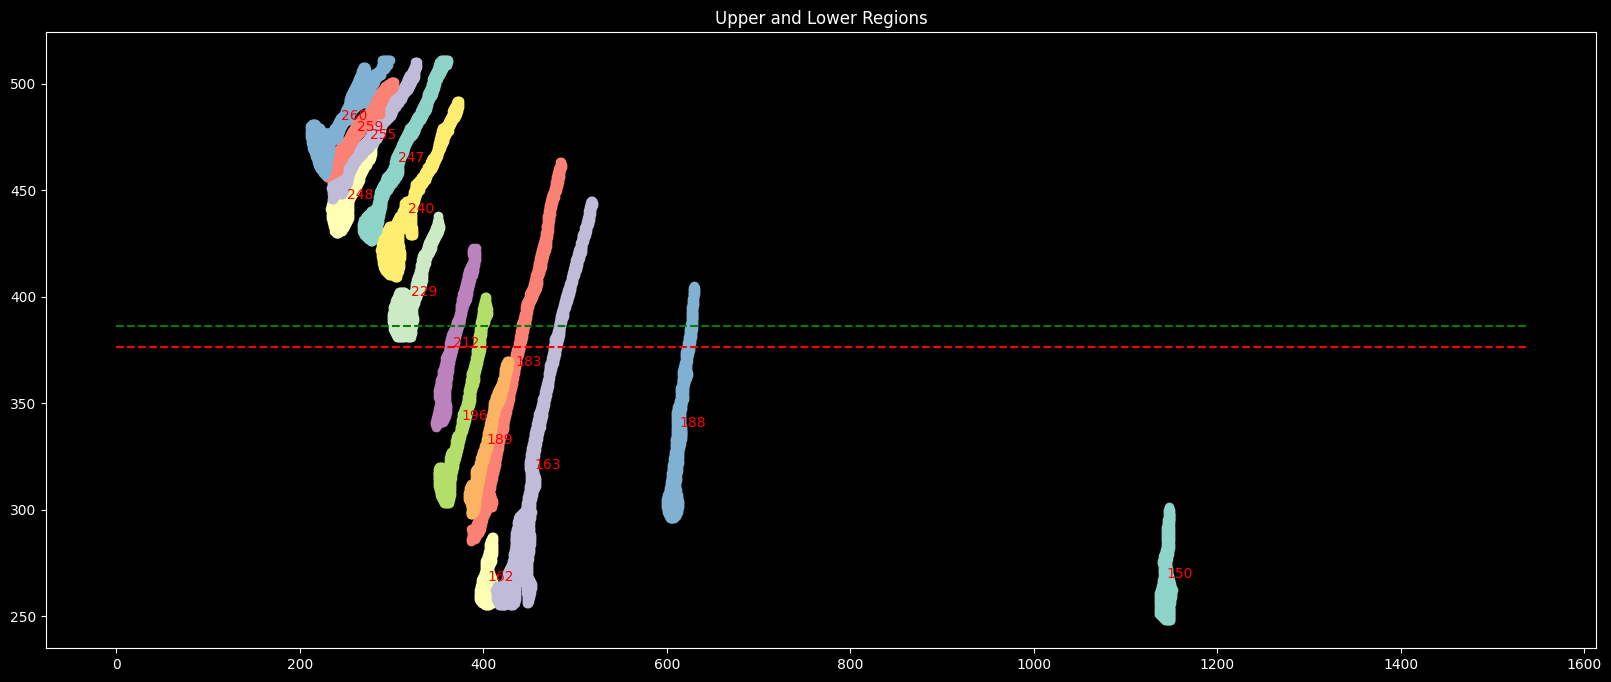

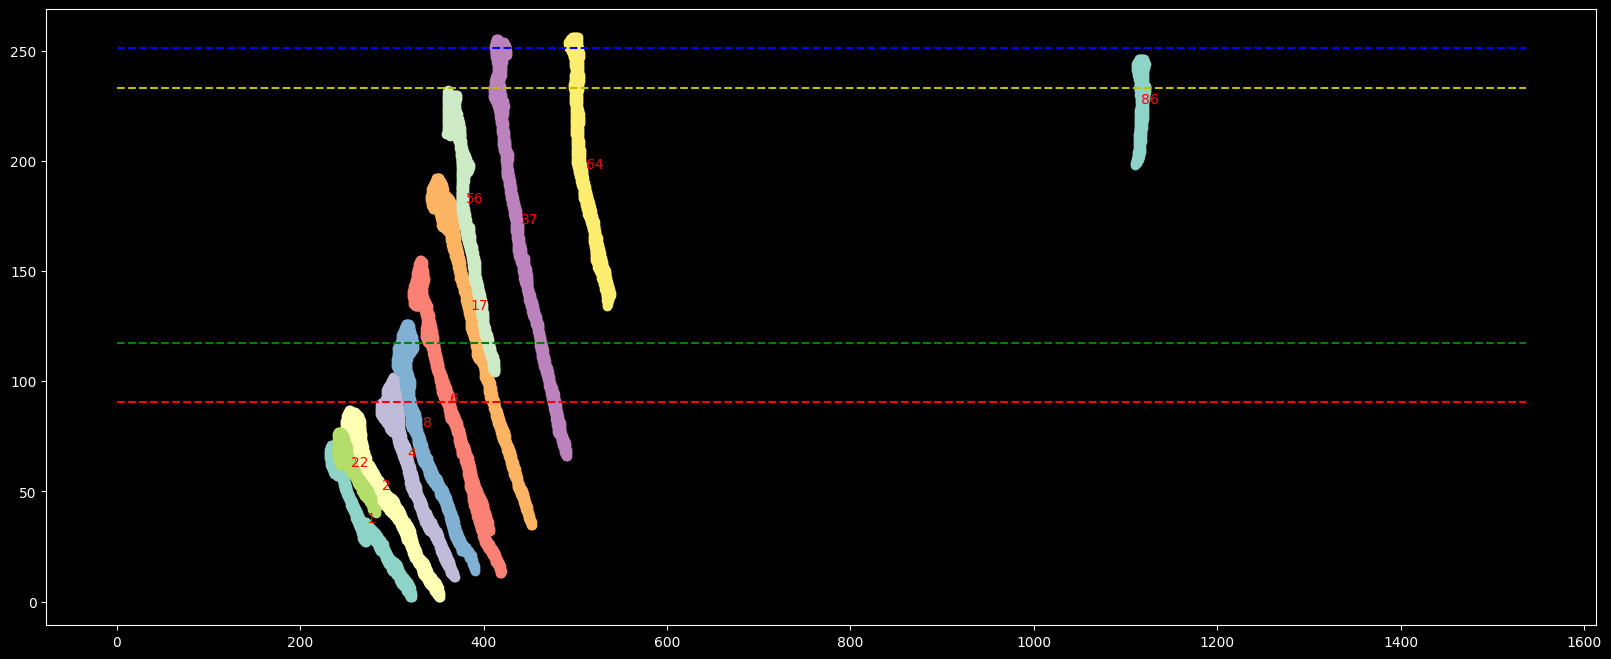

In [5]:
# Plot upper and lower regions

fig, ax = plt.subplots(figsize=(20, 8))

# Plot upper regions
means_upper = []
ax.set_title('Upper and Lower Regions')
for label in upper:
    region = np.where(masks == label)
    region = get_formated_region_coords(region)
    means_upper.append(np.mean(region, axis=0))
    ax.scatter(region[:, 0], region[:, 1])
    plt.text(np.mean(region[:, 0]), np.mean(region[:, 1]), str(label), fontsize=10, color='red')
median_upper = np.median(means_upper, axis=0)
mean_upper = np.mean(means_upper, axis=0)
plt.hlines(mean_upper[1], 0, masks.shape[1], colors='g', linestyles='dashed')
plt.hlines(median_upper[1], 0, masks.shape[1], colors='r', linestyles='dashed')

plt.show()


fig, ax = plt.subplots(figsize=(20, 8))
means_lower = []
# Plot lower regions
for label in lower:
    region = np.where(masks == label)
    region = get_formated_region_coords(region)
    means_lower.append(np.mean(region, axis=0))
    ax.scatter(region[:, 0], region[:, 1])
    plt.text(np.mean(region[:, 0]), np.mean(region[:, 1]), str(label), fontsize=10, color='red')
median_lower = np.median(means_lower, axis=0)
mean_lower = np.mean(means_lower, axis=0)
plt.hlines(median_lower[1], 0, masks.shape[1], colors='r', linestyles='dashed')
plt.hlines(mean_lower[1], 0, masks.shape[1], colors='g', linestyles='dashed')
cut_line = int((mean_upper[1] + mean_lower[1]) / 2)
cut_line_median = int((median_upper[1] + median_lower[1]) / 2)
plt.hlines(cut_line, 0, masks.shape[1], colors='b', linestyles='dashed')
plt.hlines(cut_line_median, 0, masks.shape[1], colors='y', linestyles='dashed')
plt.show()

In [6]:
line_upper, body_upper = get_line(upper, masks, True, 20)
line_lower, body_lower = get_line(lower, masks, False, 20)

# Extract points from the tuples
upper_points = np.array([point[0] for point in line_upper])
lower_points = np.array([point[0] for point in line_lower])
# top 3 points in upper region which has lowest y values
top3_min_upper = np.array(sorted(upper_points, key=lambda x: x[1])[:3])
# top 3 points in lower region which has highest y values
top3_max_lower = np.array(sorted(lower_points, key=lambda x: x[1], reverse=True)[:3])

average_min_upper = np.mean(top3_max_lower, axis=0)
average_max_lower = np.mean(top3_min_upper, axis=0)

total_min_average = (average_min_upper + average_max_lower) / 2




In [7]:

# from scipy.interpolate import splprep, splev
# from collections import defaultdict



# # Compute cumulative distance for parameter t
# def compute_cumulative_distance(points):
#     distances = np.sqrt(np.diff(points[:, 0])**2 + np.diff(points[:, 1])**2)
#     cumulative_distance = np.insert(np.cumsum(distances), 0, 0)
#     return cumulative_distance / cumulative_distance[-1]  # Normalize to [0,1]

# # t_upper = compute_cumulative_distance(upper_points)
# # t_lower = compute_cumulative_distance(lower_points)

# # Fit splines for parametric curves
# tck_upper, _ = splprep([upper_points[:, 0], upper_points[:, 1]], s=0,k=2)
# tck_lower, _ = splprep([lower_points[:, 0], lower_points[:, 1]], s=0,k=2)

# # Generate fitted points
# num_fit_points = 500
# t_fit_upper = np.linspace(0, 1, num_fit_points)
# t_fit_lower = np.linspace(0, 1, num_fit_points)
# x_fit_upper, y_fit_upper = splev(t_fit_upper, tck_upper)
# x_fit_lower, y_fit_lower = splev(t_fit_lower, tck_lower)

# # Define parametric functions
# def parametric_curve(t, tck):
#     return splev(t, tck)

# # Plotting
# plt.figure(figsize=(20, 10))

# # Plot Upper Body Points
# for i in range(len(line_upper)):
#     plt.scatter(body_upper[i][:, 0], body_upper[i][:, 1], color='lightblue', alpha=0.5)
# plt.scatter(upper_points[:, 0], upper_points[:, 1], color='blue', label='Upper Data Points')

# # Plot Fitted Upper Curve
# plt.plot(x_fit_upper, y_fit_upper, 'b-', label='Upper Spline Fit')

# # Plot Lower Body Points
# for i in range(len(line_lower)):
#     plt.scatter(body_lower[i][:, 0], body_lower[i][:, 1], color='lightcoral', alpha=0.5)
# plt.scatter(lower_points[:, 0], lower_points[:, 1], color='red', label='Lower Data Points')

# # Plot Fitted Lower Curve
# plt.plot(x_fit_lower, y_fit_lower, 'r-', label='Lower Spline Fit')

# plt.legend()
# plt.xlabel('X-axis')
# plt.ylabel('Y-axis')
# plt.title('Data Points and Fitted Parametric Curves')
# plt.show()

# # Example usage of parametric functions
# t_new = 1  # Midpoint
# x_upper, y_upper = parametric_curve(t_new, tck_upper)
# x_lower, y_lower = parametric_curve(t_new, tck_lower)

# print(f"Upper Curve at t={t_new}: (x, y) = ({x_upper:.2f}, {y_upper:.2f})")
# print(f"Lower Curve at t={t_new}: (x, y) = ({x_lower:.2f}, {y_lower:.2f})")

No intersection found for process 84
No intersection found for process 96
No intersection found for process 97
No intersection found for process 99


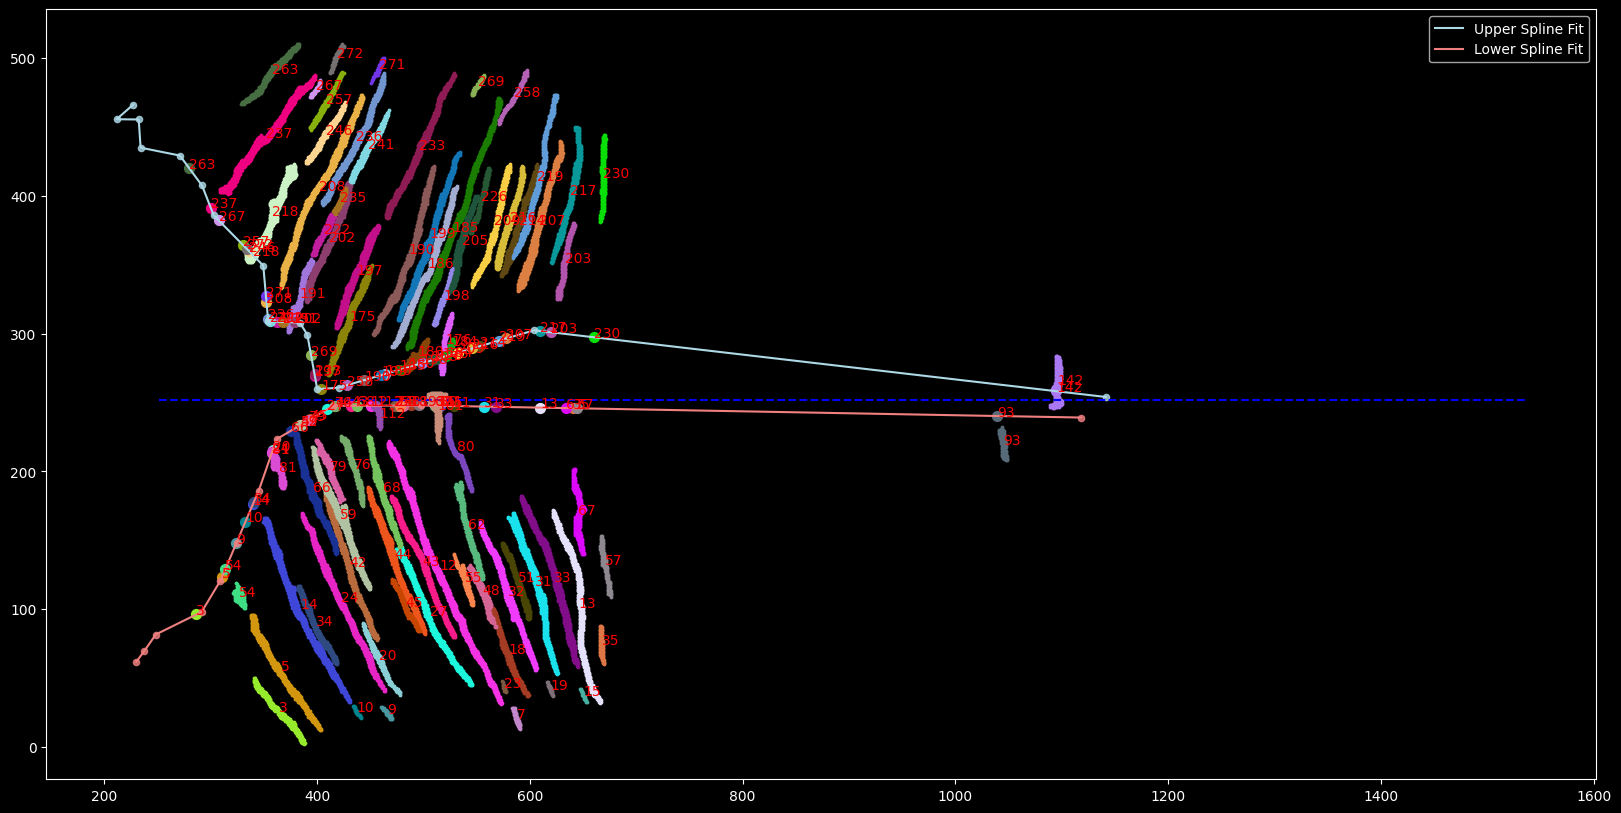

In [8]:
t_upper, tck_upper, x_fit_upper, y_fit_upper, total_length_upper = parametrize_curve(upper_points)
t_lower, tck_lower, x_fit_lower, y_fit_lower, total_length_lower = parametrize_curve(lower_points)

plt.figure(figsize=(20, 10))
processes_upper = processes["upper"]


intersection_list_upper = get_all_intersections(tck_upper,t_upper,ab_list_upper,upper=True)
intersection_list_lower = get_all_intersections(tck_lower,t_lower,ab_list_lower,upper=False)

for label, (t, x, y),d in intersection_list_upper:
    random_color = np.random.rand(3,)
    plt.scatter(x, y, color=random_color, s=50)

    coords = get_formated_region_coords(np.where(masks == label))
    plt.scatter(coords[:, 0], coords[:, 1], color=random_color, s=3)
    plt.text(np.mean(coords[:, 0]), np.mean(coords[:, 1]), str(label), fontsize=10, color='red')
    plt.text(x, y, str(label), fontsize=10, color='red')

for label, (t, x, y),d in intersection_list_lower:
    random_color = np.random.rand(3,)
    plt.scatter(x, y, color=random_color, s=50)
    coords = get_formated_region_coords(np.where(masks == label))
    plt.scatter(coords[:, 0], coords[:, 1], color=random_color, s=3)
    plt.text(np.mean(coords[:, 0]), np.mean(coords[:, 1]), str(label), fontsize=10, color='red')
    plt.text(x, y, str(label), fontsize=10, color='red')
    

plot_parametrized_curve(upper_points, x_fit_upper, y_fit_upper ,color='lightblue', label='Upper Spline Fit')


plot_parametrized_curve(lower_points, x_fit_lower, y_fit_lower, color='lightcoral', label='Lower Spline Fit')
plt.hlines(total_min_average[1],total_min_average[1], masks.shape[1], colors='b', linestyles='dashed')
plt.legend()
plt.show()


In [16]:
aligned_upper,cor_matrix_upper_comp = uniform_align_comp_cell(line_upper, masks, True)
aligned_lower,cor_matrix_lower_comp = uniform_align_comp_cell(line_lower, masks, False)

aligned_process_upper,cor_matrix_upper_p = uniform_align_processes(intersection_list_upper,masks,True)
aligned_process_lower,cor_matrix_lower_p= uniform_align_processes(intersection_list_lower,masks,False)

subsegmented_matrix = sub_segment(cor_matrix_upper_comp,10)
sub_segmented_labels = np.unique(subsegmented_matrix[:,1])

subsegment_mask = create_cp_mask(subsegmented_matrix,masks)
new_mask_file = np.copy(masks_file)

file_path = r"C:\Users\javid.rezai\YaksiLab\astroglialAnalysis\tests\data\subsegment_mask.npy"

new_mask_file.item()['masks'] = subsegment_mask
np.save(file_path,new_mask_file)

# plt.figure(figsize=(20, 10))
# plt.imshow(subsegment_mask)
# plt.show()

# plt.figure(figsize=(20, 7))
# i =0
# for (l,up) in aligned_upper:
#     plt.scatter(up[:, 0], up[:, 1],s=3)
#     plt.text(np.mean(up[:, 0]), np.mean(up[:, 1]), str(line_upper[i][1]), fontsize=10, color='red')
#     i+=1

# for (label, coords) in aligned_process_upper:
#     r_color = np.random.rand(3,)
#     plt.scatter(coords[:, 0], coords[:, 1], color=r_color,s=3)
#     plt.text(np.mean(coords[:, 0]), np.mean(coords[:, 1]), str(label), fontsize=10, color='red')
# plt.hlines(0, 0, masks.shape[1], colors='b', linestyles='dashed')
# plt.title('Aligned Upper Part')
# plt.show()

# i = 0
# plt.figure(figsize=(20, 7))
# for (label, coords) in aligned_process_lower:
#     r_color = np.random.rand(3,)
#     plt.scatter(coords[:, 0], coords[:, 1], color=r_color,s=3)
#     plt.text(np.mean(coords[:, 0]), np.mean(coords[:, 1]), str(label), fontsize=10, color='red')
    
# for (l,low) in aligned_lower:
#     plt.scatter(low[:, 0], low[:, 1],s=3)
#     plt.text(np.mean(low[:, 0]), np.mean(low[:, 1]), str(line_lower[i][1]), fontsize=10, color='red')
#     i+=1
# plt.hlines(0, 0, masks.shape[1], colors='b', linestyles='dashed')
# plt.title('Aligned Lower Part')
# plt.show()

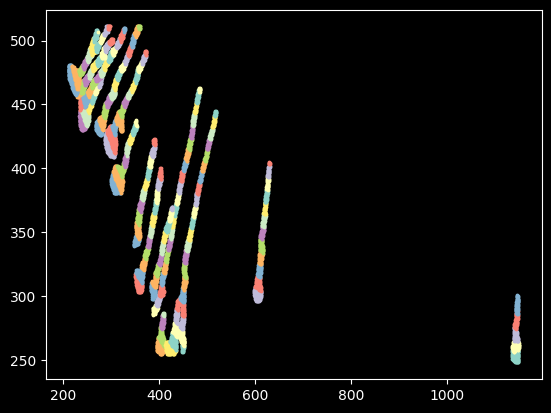

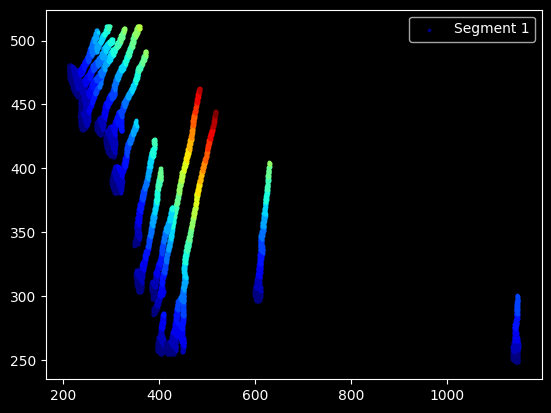

In [10]:
# subsegmented_matrix = [cell label, subsegment label, subsegment number, rotated x,rotated y, original x, original y]

for l in sub_segmented_labels:
    label_rows = subsegmented_matrix[subsegmented_matrix[:,1] == l]
    original_coords = np.array([label_rows[:,3],label_rows[:,4]])
    plt.scatter(original_coords[0],original_coords[1],s=3)
plt.show()
# Assign colors based on segment number
unique_segments = np.unique(subsegmented_matrix[:, 2])
colors = plt.cm.jet(np.linspace(0, 1, len(unique_segments)))

for l in sub_segmented_labels:
    label_rows = subsegmented_matrix[subsegmented_matrix[:, 1] == l]
    original_coords = np.array([label_rows[:, 3], label_rows[:, 4]])
    segment_number = label_rows[0, 2]
    color = colors[np.where(unique_segments == segment_number)[0][0]]
    plt.scatter(original_coords[0], original_coords[1], s=3, color=color, label=f'Segment {segment_number}' if l == sub_segmented_labels[0] else "")

plt.legend()
plt.show()

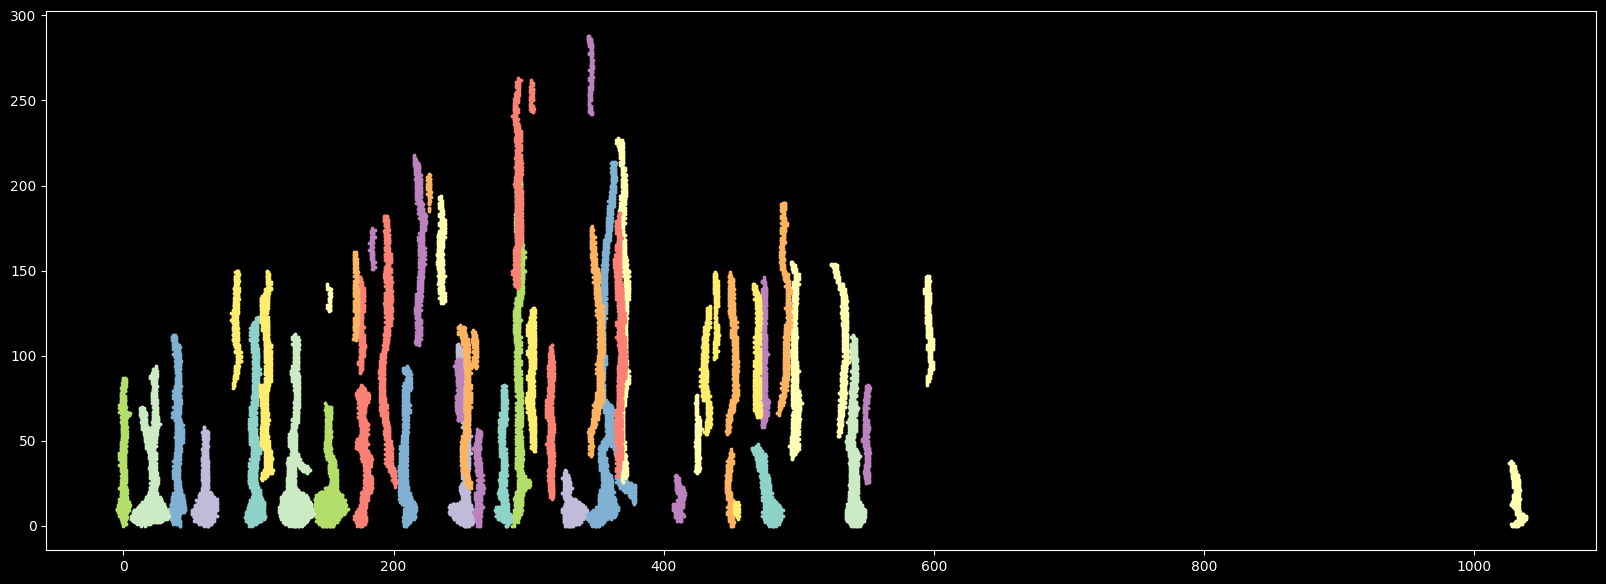

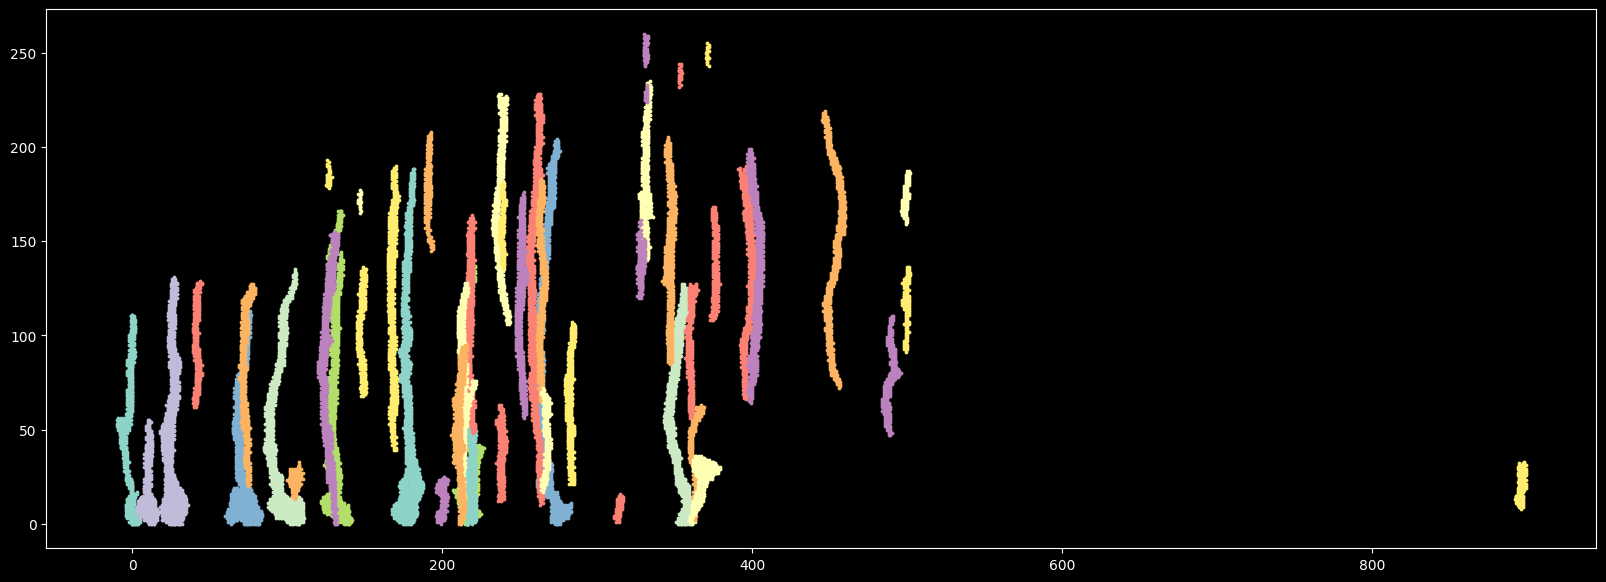

In [11]:

upper_comp_labels = np.unique(cor_matrix_upper_comp[:,0])
lower_comp_labels = np.unique(cor_matrix_lower_comp[:,0])
upper_p_labels = np.unique(cor_matrix_upper_p[:,0])
lower_p_labels = np.unique(cor_matrix_lower_p[:,0])

upper_labels = np.concatenate((upper_comp_labels,upper_p_labels)) 
lower_labels = np.concatenate((lower_comp_labels,lower_p_labels))


plt.figure(figsize=(20, 7))
for l in upper_labels:
    labe_coords = cor_matrix_upper_comp[cor_matrix_upper_comp[:,0] == l]
    rotated_coords = np.array([labe_coords[:,3],labe_coords[:,4]])
    plt.scatter(rotated_coords[0],rotated_coords[1],s=3)

    labe_coords = cor_matrix_upper_p[cor_matrix_upper_p[:,0] == l]
    rotated_coords = np.array([labe_coords[:,3],labe_coords[:,4]])
    plt.scatter(rotated_coords[0],rotated_coords[1],s=3)
plt.show()

plt.figure(figsize=(20, 7))

for l in lower_labels:


    labe_coords = cor_matrix_lower_comp[cor_matrix_lower_comp[:,0] == l]
    rotated_coords = np.array([labe_coords[:,3],labe_coords[:,4]])
    plt.scatter(rotated_coords[0],rotated_coords[1],s=3)


    labe_coords = cor_matrix_lower_p[cor_matrix_lower_p[:,0] == l]
    rotated_coords = np.array([labe_coords[:,3],labe_coords[:,4]])
    plt.scatter(rotated_coords[0],rotated_coords[1],s=3)

plt.show()

In [12]:
# for region in aligned_upper:
#     subsemgents = subsegment_region_y_axis(region, 10)
#     visualize_subsegments(subsemgents)
# plt.show()

In [13]:
# path = r"C:\Users\javid.rezai\YaksiLab\subsegmented_masks_seg.npy"

# mask_file = np.load(path, allow_pickle=True).item()
# masks = mask_file['masks']

# labels = np.unique(masks)
# labels = labels[labels != 0]
# plt.figure(figsize=(20, 10))
# for label in labels:
#     region = np.where(masks == label)
#     region = get_formated_region_coords(region)
#     plt.scatter(region[:, 0], region[:, 1])
#     # plt.text(region[0][0], region[0][1], str(label),fontsize=8,c='r')

# plt.show()